In [16]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

In [21]:
feature_params = dict(maxCorners=100, qualityLevel=0.001, minDistance=7, blockSize=14)
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

old_frame = cv2.imread('images_from_cam/0.05.jpg')
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
mask = np.zeros_like(old_frame)
f = os.listdir('images_from_cam')
R = 0

focal_length = old_frame.shape[1]
K = np.array([[focal_length, 0, 1],
              [0, focal_length, 1],
              [0, 0, 1]])

# point_cloud.points = o3d.utility.Vector3dVector()
# point_cloud = o3d.geometry.PointCloud()

transpose = [[0],[0]]
rotate = [[0],[0]]
ttttt = []
for filename in f[2:200]:
    frame = cv2.imread(os.path.join('images_from_cam',filename))
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    if len(p1):
        good_new = p1[st == 1]
        good_old = p0[st == 1]
    else:
        transpose[0].append(transpose[0][-1])
        transpose[1].append(transpose[1][-1])
        rotate[0].append(rotate[0][-1])
        rotate[1].append(rotate[1][-1])
        continue
        

    # Эпиполярная геометрия: нахождение фундаментальной матрицы
    F, mask = cv2.findFundamentalMat(good_old, good_new, cv2.FM_RANSAC)

    # Нахождение относительных позиций камер (эпиполярная геометрия)
    points, R, t, mask_pose = cv2.recoverPose(F, good_old, good_new, K)

    
    
    rotate[0].append(R[0][1] )
    rotate[1].append(R[1][2] + rotate[1][-1])

    ttttt.append(R[2][2])
    
    transpose[0].append(t[0][0] * rotate[0][-1]  + transpose[0][-1])
    transpose[1].append(t[1][0]  + transpose[1][-1])

    # Триангуляция точек
    proj1 = np.dot(K, np.hstack((np.eye(3), np.zeros((3,1)))))
    proj2 = np.dot(K, np.hstack((R, t)))
    pts4D_hom = cv2.triangulatePoints(proj1, proj2, good_old.T, good_new.T)
    pts3D = pts4D_hom[:3] / pts4D_hom[3]
    # v = o3d.utility.Vector3dVector(pts3D.T)
    
    # point_cloud.points.extend(v)
       
    

   

    # for i, (new, old) in enumerate(zip(good_new, good_old)):
    #     a, b = new.ravel()
    #     c, d = old.ravel()
    #     mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    #     frame = cv2.circle(frame, (int(a), int(b)), 1, (0, 0, 255), -1)
    # img = cv2.add(frame, mask)
    
    # # Display the result
    # plt.imshow(img)

    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    
# o3d.visualization.draw_geometries([point_cloud])


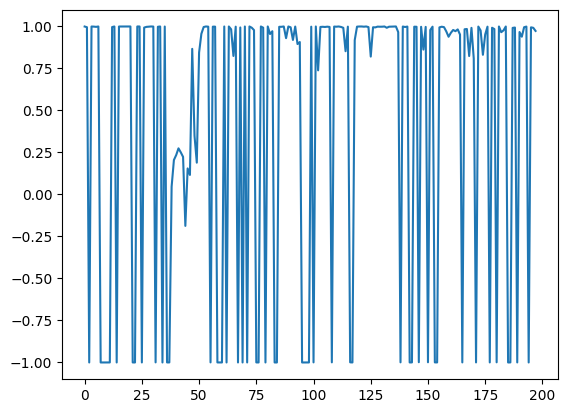

In [22]:
plt.plot(range(len(ttttt)), ttttt)

In [ ]:
plt.scatter(transpose[0], transpose[1])

In [ ]:
feature_params = dict(maxCorners=100, qualityLevel=0.001, minDistance=7, blockSize=14)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
old_frame = cv2.imread('images_from_cam/0.05.jpg')
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect feature points

p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

f = os.listdir('images_from_cam')

R = 0
point_cloud.points = o3d.utility.Vector3dVector()
point_cloud = o3d.geometry.PointCloud()
for filename in f[30:31]:
    frame = cv2.imread(os.path.join('images_from_cam',filename))
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Select good points
    try:
        good_new = p1[st == 1]
        good_old = p0[st == 1]
    except:
        continue
        
    pts1 = good_old
    pts2 = good_new
    # Эпиполярная геометрия: нахождение фундаментальной матрицы
    K = np.array([[img1.shape[0], 0, img1.shape[1]/2],
              [0, img1.shape[0], img1.shape[0]/2],
              [0, 0, 1]])
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    points, R, t, mask_pose = cv2.recoverPose(F, pts1, pts2, K)
    
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 1, (0, 0, 255), -1)
        img = cv2.add(frame, mask)
    
    # Display the result
    plt.imshow(img)
    

    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    
